# KNN - BINARY CLASSIFICATION (con 1he di titleType)

In [184]:
import ast
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

In [185]:
train_df = pd.read_csv("pp_train.csv")
test_df = pd.read_csv("pp_test.csv")

copy_train = train_df.copy()
copy_test = test_df.copy()

In [186]:
copy_train.columns

Index(['originalTitle', 'rating', 'startYear', 'endYear', 'runtimeMinutes',
       'awardWins', 'numVotes', 'totalImages', 'totalVideos', 'totalCredits',
       'criticReviewsTotal', 'titleType', 'awardNominationsExcludeWins',
       'canHaveEpisodes', 'numRegions', 'userReviewsTotal', 'is_Documentary',
       'is_History', 'is_Adventure', 'is_Thriller', 'is_Game-Show',
       'is_Comedy', 'is_Sci-Fi', 'is_Romance', 'is_Biography', 'is_Musical',
       'is_Western', 'is_Music', 'is_Film-Noir', 'is_Adult', 'is_Reality-TV',
       'is_News', 'is_Action', 'is_Crime', 'is_Short', 'is_Fantasy',
       'is_Family', 'is_Mystery', 'is_Talk-Show', 'is_Drama', 'is_Sport',
       'is_War', 'is_Horror', 'is_Animation', 'is_from_Oceania',
       'is_from_North America', 'is_from_South America', 'is_from_Asia',
       'is_from_Africa', 'is_from_Europe', 'countryOfOrigin',
       'countryOfOrigin_freq_enc', 'countryOfOrigin_NA', 'countryOfOrigin_AF',
       'countryOfOrigin_AS', 'countryOfOrigin_EU',

#### Deleting outliers

In [187]:
copy_train = copy_train[copy_train["outlier_w_type"] != True]
copy_test = copy_test[copy_test["outlier_w_type"] != True]

#### Creation of the target variable

In [188]:
copy_train['has_lowEngagement'] = (copy_train['numVotes'] < 100).astype(int)
copy_test['has_lowEngagement'] = (copy_test['numVotes'] < 100).astype(int)

In [189]:
x = sum(copy_train["has_lowEngagement"] == 1)
x

10287

#### Selection of the target variable

In [190]:
y_train = np.array(copy_train['has_lowEngagement'])  # Il target originale
y_test = np.array(copy_test["has_lowEngagement"])

In [191]:
title_type_dummies_tr = pd.get_dummies(copy_train['titleType'], prefix='titleType')
title_type_dummies_ts = pd.get_dummies(copy_test['titleType'], prefix='titleType')

copy_train = pd.concat([copy_train, title_type_dummies_tr], axis=1)
copy_test = pd.concat([copy_test, title_type_dummies_ts], axis=1)

In [192]:
# --- Le tue colonne ---
num_cols = [
        'startYear', 
        'totalNominations', 
        'totalMedia', 
       'totalCredits', 
       #'criticReviewsTotal', 
       'canHaveEpisodes', 
       'numRegions', 
       'userReviewsTotal',
       #"fill_runtimeMinutes",
       'fill_runtimeMinutes_Bruno',
       #'runtimeMinutes_notitletype',
       "rating", 
       'countryOfOrigin_freq_enc',
    #    'countryOfOrigin_NA', 'countryOfOrigin_AF',
    #    'countryOfOrigin_AS', 'countryOfOrigin_EU', 'countryOfOrigin_OC',
    #    'countryOfOrigin_SA', 'countryOfOrigin_UNK',
    #    'is_Documentary',
    #    'is_History', 'is_Adventure', 'is_Thriller', 'is_Game-Show',
    #    'is_Comedy', 'is_Sci-Fi', 'is_Romance', 'is_Biography', 'is_Musical',
    #    'is_Western', 'is_Music', 'is_Film-Noir', 'is_Adult', 'is_Reality-TV',
    #    'is_News', 'is_Action', 'is_Crime', 'is_Short', 'is_Fantasy',
    #    'is_Family', 'is_Mystery', 'is_Talk-Show', 'is_Drama', 'is_Sport',
    #    'is_War', 'is_Horror', 'is_Animation'
    ]

one_hot_cols = [
    'titleType_movie', 'titleType_short', 'titleType_tvEpisode', 'titleType_tvMiniSeries', ''
    'titleType_tvMovie', 'titleType_tvSeries', 'titleType_tvSpecial', 'titleType_video'
]

# --- Scaler ---
scaler = StandardScaler()
X_train_scaled_num = pd.DataFrame(
    scaler.fit_transform(copy_train[num_cols]),
    columns=num_cols,
    index=copy_train.index
)
X_test_scaled_num = pd.DataFrame(
    scaler.transform(copy_test[num_cols]),
    columns=num_cols,
    index=copy_test.index
)

# --- Mantieni le one-hot invariate ---
X_train_onehot = copy_train[one_hot_cols]
X_test_onehot = copy_test[one_hot_cols]

# --- Unisci ---
X_train_temp = pd.concat([X_train_scaled_num, X_train_onehot], axis=1)
X_test_temp = pd.concat([X_test_scaled_num, X_test_onehot], axis=1)

# --- Ricostruisci l'ordine originale delle colonne ---
original_cols = [col for col in copy_train.columns if col in num_cols + one_hot_cols]

X_train_final = X_train_temp[original_cols]
X_test_final = X_test_temp[original_cols]

#### Splitting the dataset in train and validation

In [193]:
from sklearn.model_selection import train_test_split

# Supponiamo che y_train siano le etichette corrispondenti a X_train_final
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_final, y_train, 
    test_size=0.2,         # 20% validation
    random_state=42)      # per rendere la suddivisione riproducibile

#### Computation of the proper k

In [194]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score

def optimize_knn_with_external_validation(X_train, y_train, X_val, y_val, n_iter=100, cv=5, verbose=1):
    # Calcolo range k
    sqrt_n = int(np.sqrt(X_train.shape[0]))
    
    param_distributions = {
        "n_neighbors": np.arange(1, sqrt_n + 1),
        "weights": ["uniform", "distance"],
        "metric": ["euclidean", "cityblock"]
    }
    
    random_search = RandomizedSearchCV(
        KNeighborsClassifier(),
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=StratifiedKFold(n_splits=cv, shuffle=True, random_state=42),
        n_jobs=-1,
        refit=True,
        random_state=42,
        verbose=verbose,
        scoring='accuracy',
        return_train_score=True
    )

    # Fit solo sul training set
    random_search.fit(X_train, y_train)
#
    # Valutazione su validation set
    best_model = random_search.best_estimator_
    y_val_pred = best_model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)

    # Mostra le top 5 configurazioni (sulla cross-validation)
    results = random_search.cv_results_
    sorted_idx = np.argsort(results['rank_test_score'])
    print("\nTop 5 configurations (CV scores):")
    for i in range(5):
        idx = sorted_idx[i]
        print(f"Rank {i+1}: {results['params'][idx]}")
        print(f"   CV Test score: {results['mean_test_score'][idx]:.4f}")
        print(f"   CV Train score: {results['mean_train_score'][idx]:.4f}")

    print(f"\nValidation Accuracy of Best Model: {val_accuracy:.4f}")

    return best_model, random_search.best_params_, val_accuracy

In [195]:
# best_knn, best_params, best_score = optimize_knn(X_train2_standardsc, y_train2)

best_knn, best_params, val_score = optimize_knn_with_external_validation(
    X_train_split, y_train_split, X_val_split, y_val_split)


# # Create a new classifier with the optimized parameters
clf = KNeighborsClassifier(**best_params)
clf.fit(X_train_split, y_train_split)

y_pred = clf.predict(X_val_split)

Fitting 5 folds for each of 100 candidates, totalling 500 fits

Top 5 configurations (CV scores):
Rank 1: {'weights': 'uniform', 'n_neighbors': 9, 'metric': 'cityblock'}
   CV Test score: 0.8343
   CV Train score: 0.8583
Rank 2: {'weights': 'distance', 'n_neighbors': 5, 'metric': 'cityblock'}
   CV Test score: 0.8334
   CV Train score: 1.0000
Rank 3: {'weights': 'distance', 'n_neighbors': 14, 'metric': 'cityblock'}
   CV Test score: 0.8332
   CV Train score: 1.0000
Rank 4: {'weights': 'distance', 'n_neighbors': 24, 'metric': 'cityblock'}
   CV Test score: 0.8293
   CV Train score: 1.0000
Rank 5: {'weights': 'distance', 'n_neighbors': 9, 'metric': 'euclidean'}
   CV Test score: 0.8290
   CV Train score: 1.0000

Validation Accuracy of Best Model: 0.8298


#### Training the model (on the x_train_split)

In [ ]:
# clf = KNeighborsClassifier(weights = 'uniform', n_neighbors= 9 , metric = 'cityblock')
# clf.fit(X_train_split, y_train_split)

# y_pred = clf.predict(X_val_split)

#### Checking if the model overfits

Performance sul Training set:
Accuracy: 0.8607
F1 Score: 0.8536

Performance sul Validation set:
Accuracy: 0.8298
F1 Score: 0.8198


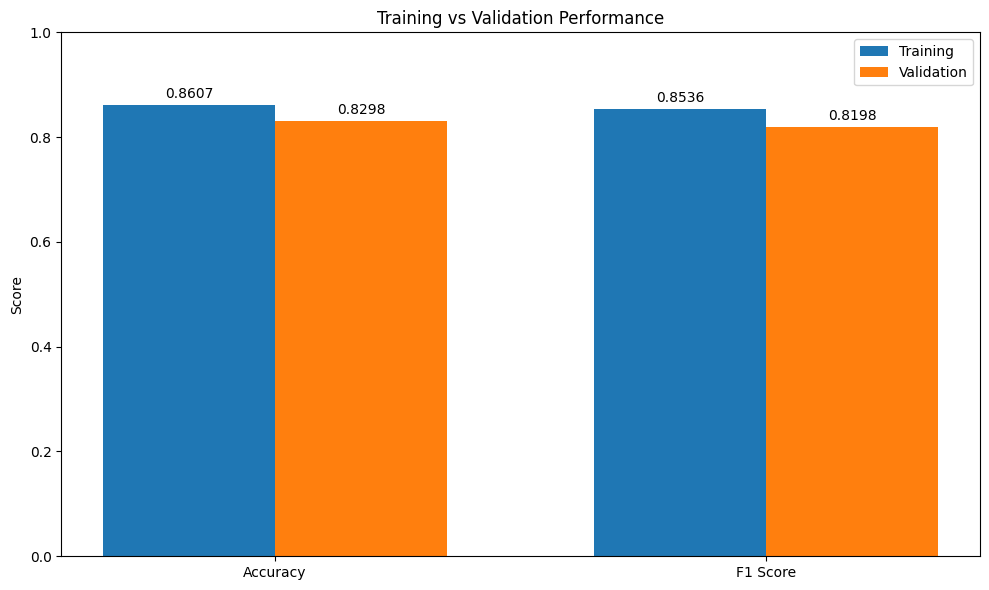

In [197]:
# Importazioni necessarie (se non già importate)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Valutazione sul training set
y_pred_train = clf.predict(X_train_split)
train_accuracy = accuracy_score(y_train_split, y_pred_train)
train_f1 = f1_score(y_train_split, y_pred_train, average='weighted')

# Valutazione sul validation set
y_pred_val = clf.predict(X_val_split)
val_accuracy = accuracy_score(y_val_split, y_pred_val)
val_f1 = f1_score(y_val_split, y_pred_val, average='weighted')

# Stampa dei risultati
print(f"Performance sul Training set:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"F1 Score: {train_f1:.4f}")
print("\nPerformance sul Validation set:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"F1 Score: {val_f1:.4f}")

# Visualizzazione grafica del confronto
metrics = ['Accuracy', 'F1 Score']
train_scores = [train_accuracy, train_f1]
val_scores = [val_accuracy, val_f1]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, train_scores, width, label='Training')
rects2 = ax.bar(x + width/2, val_scores, width, label='Validation')

ax.set_ylabel('Score')
ax.set_title('Training vs Validation Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)

# Aggiungi i valori sopra le barre
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

#### Performance evaluation (validation set)

In [198]:
class_names = ['high_engagement', 'low_engagement']

# Performance evaluation con nomi semantici
print(f"Validation accuracy: {accuracy_score(y_val_split, y_pred)}")
print("\nClassification Report:")
print(classification_report(y_val_split, y_pred, target_names=class_names))

Validation accuracy: 0.8298228017385489

Classification Report:
                 precision    recall  f1-score   support

high_engagement       0.84      0.58      0.68       946
 low_engagement       0.83      0.95      0.88      2045

       accuracy                           0.83      2991
      macro avg       0.83      0.76      0.78      2991
   weighted avg       0.83      0.83      0.82      2991



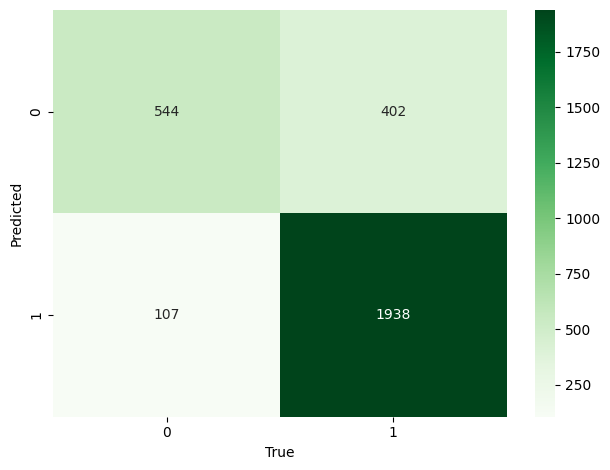

In [199]:
classes_unique = np.unique(y_val_split)
cm = confusion_matrix(y_val_split, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=classes_unique, 
            yticklabels=classes_unique)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.tight_layout()
plt.show()

#### Training the model (on the x_train_final)

In [200]:
clf = KNeighborsClassifier(weights = 'uniform', n_neighbors= 8, metric = 'cityblock')
clf.fit(X_train_final, y_train)

y_pred = clf.predict(X_test_final)

Performance sul Training set:
Accuracy: 0.8696
F1 Score: 0.8661

Performance sul Test set:
Accuracy: 0.8298
F1 Score: 0.8198


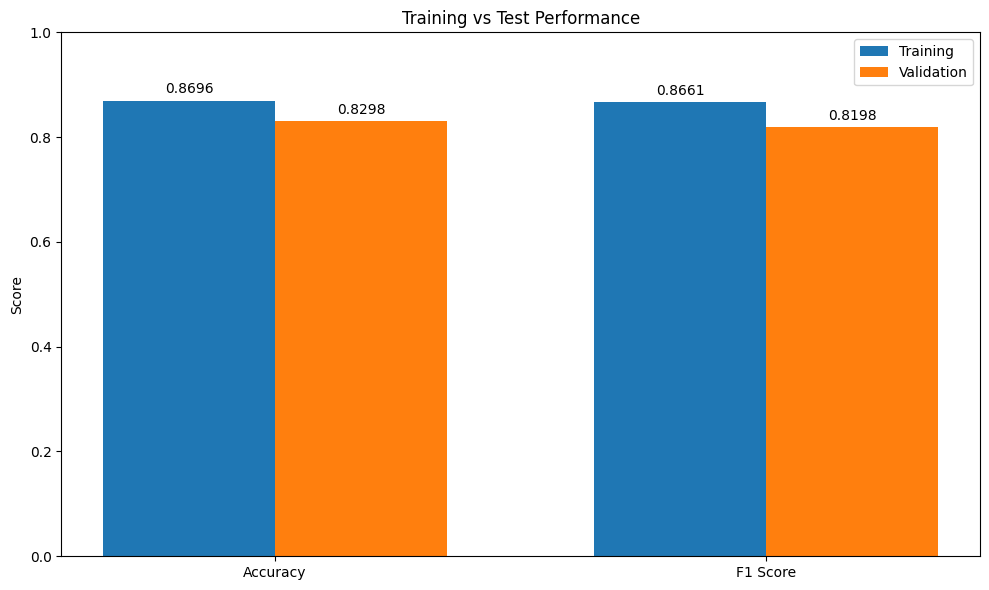

In [201]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Valutazione sul training set
y_pred_train = clf.predict(X_train_final)
train_accuracy = accuracy_score(y_train, y_pred_train)
train_f1 = f1_score(y_train, y_pred_train, average='weighted')

# Valutazione sul test set
y_pred_test = clf.predict(X_test_final)
test_accuracy = accuracy_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred, average='weighted')

# Stampa dei risultati
print(f"Performance sul Training set:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"F1 Score: {train_f1:.4f}")
print("\nPerformance sul Test set:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"F1 Score: {val_f1:.4f}")

# Visualizzazione grafica del confronto
metrics = ['Accuracy', 'F1 Score']
train_scores = [train_accuracy, train_f1]
test_scores = [test_accuracy, val_f1]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, train_scores, width, label='Training')
rects2 = ax.bar(x + width/2, val_scores, width, label='Validation')

ax.set_ylabel('Score')
ax.set_title('Training vs Test Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)

# Aggiungi i valori sopra le barre
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

#### Performance evaluation (on the test set)

In [204]:
class_names = ['high_engagement', 'low_engagement']

# Performance evaluation con nomi semantici
print(f"Test accuracy: {accuracy_score(y_test, y_pred)}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

Test accuracy: 0.8253968253968254

Classification Report:
                 precision    recall  f1-score   support

high_engagement       0.77      0.63      0.69      1561
 low_engagement       0.84      0.92      0.88      3416

       accuracy                           0.83      4977
      macro avg       0.81      0.77      0.79      4977
   weighted avg       0.82      0.83      0.82      4977



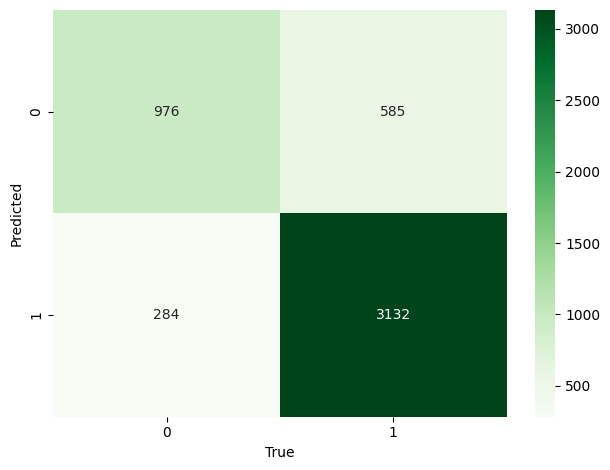

In [203]:
classes_unique = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=classes_unique, 
            yticklabels=classes_unique)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.tight_layout()
plt.show()